<a href="https://colab.research.google.com/github/JennGuz/image-classifier-project/blob/main/image_classifier_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow


In [39]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [5]:
zip_file = "/content/train.zip"

if os.path.exists(zip_file):
    print(f"Archivo encontrado: {zip_file}")
else:
    print(f"Archivo no encontrado: {zip_file}")

try:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall("./")
        print("Archivo descomprimido con éxito.")
        print("Archivos extraídos:", os.listdir("./"))
except zipfile.BadZipFile:
    print("Error: El archivo no es un archivo .zip válido.")


Archivo encontrado: /content/train.zip
Archivo descomprimido con éxito.
Archivos extraídos: ['.config', 'train', 'test1', '.ipynb_checkpoints', 'test1.zip', 'train.zip', 'sample_data']


In [4]:
zip_file_2 = "/content/test1.zip"

if os.path.exists(zip_file_2):
    print(f"Archivo encontrado: {zip_file_2}")
else:
    print(f"Archivo no encontrado: {zip_file_2}")

try:
    with zipfile.ZipFile(zip_file_2, 'r') as zip_ref:
        zip_ref.extractall("./")
        print("Archivo descomprimido con éxito.")
        print("Archivos extraídos:", os.listdir("./"))
except zipfile.BadZipFile:
    print("Error: El archivo no es un archivo .zip válido.")

Archivo encontrado: /content/test1.zip
Archivo descomprimido con éxito.
Archivos extraídos: ['.config', 'test1', '.ipynb_checkpoints', 'test1.zip', 'sample_data']


In [6]:
base_dir = "/content/train"

if not os.path.exists(base_dir):
    print(f"Error: La carpeta {base_dir} no existe.")
else:
    train_images = os.listdir(base_dir)
    print(f"Se encontraron imágenes en {base_dir}.")

Se encontraron imágenes en /content/train.


In [7]:
cat_dir = os.path.join(base_dir, "cat")
dog_dir = os.path.join(base_dir, "dog")

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

labels = []
for image in os.listdir(base_dir):
    if os.path.isfile(os.path.join(base_dir, image)):
        if 'cat' in image:
            shutil.move(os.path.join(base_dir, image), os.path.join(cat_dir, image))
            labels.append({'image': image, 'label': 'cat'})
        elif 'dog' in image:
            shutil.move(os.path.join(base_dir, image), os.path.join(dog_dir, image))
            labels.append({'image': image, 'label': 'dog'})

print(f"Imágenes en la carpeta 'cat': {len(os.listdir(cat_dir))}")
print(f"Imágenes en la carpeta 'dog': {len(os.listdir(dog_dir))}")

Imágenes en la carpeta 'cat': 12500
Imágenes en la carpeta 'dog': 12500


In [9]:
df = pd.DataFrame(labels)
df.head()

,image,label
0,dog.7972.jpg,dog
1,cat.5043.jpg,cat
2,cat.10121.jpg,cat
3,dog.1216.jpg,dog
4,dog.4798.jpg,dog


In [10]:
df.describe()

,image,label
count,25000,25000
unique,25000,2
top,cat.3086.jpg,dog
freq,1,12500


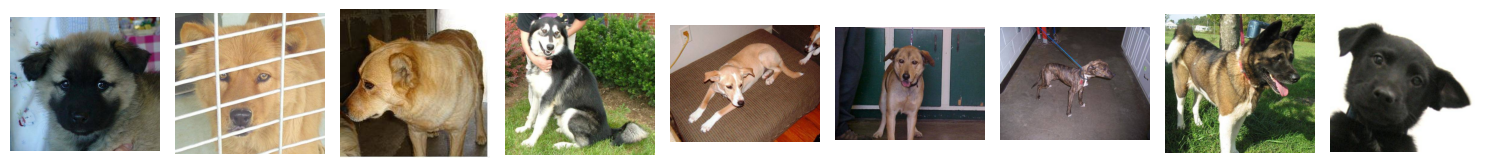

In [11]:
dog_images = df[df['label'] == "dog"]['image']

fig, ax = plt.subplots(1, 9, figsize=(15, 15))

for i, image_path in enumerate(dog_images[:9]):
    img = Image.open(f"/content/train/dog/{image_path}")
    ax[i].imshow(img)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

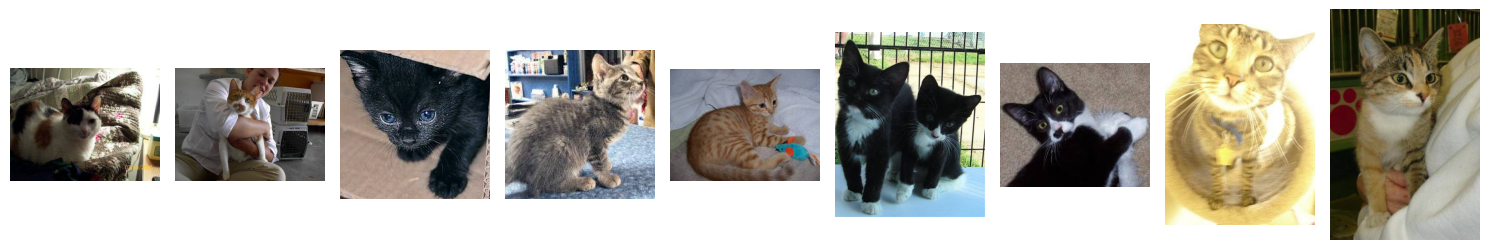

In [12]:
cat_images = df[df['label'] == "cat"]['image']

fig, ax = plt.subplots(1, 9, figsize=(15, 15))

for i, image_path in enumerate(cat_images[:9]):
    img = Image.open(f"/content/train/cat/{image_path}")
    ax[i].imshow(img)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
def resize_images(image_path, output_size = (224, 224)):
    img = Image.open(image_path)
    img = img.resize(output_size, Image.LANCZOS)
    return img

In [14]:
for image in os.listdir(cat_dir):
    img = resize_images(os.path.join(cat_dir, image))
    img.save(os.path.join(cat_dir, image))

In [15]:
for image in os.listdir(dog_dir):
    img = resize_images(os.path.join(dog_dir, image))
    img.save(os.path.join(dog_dir, image))

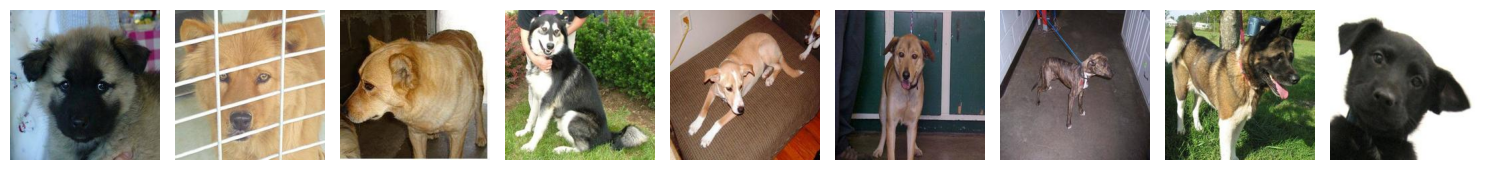

In [16]:
fig, ax = plt.subplots(1, 9, figsize=(15, 15))

for i, image_path in enumerate(dog_images[:9]):
    img = Image.open(f"/content/train/dog/{image_path}")
    ax[i].imshow(img)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

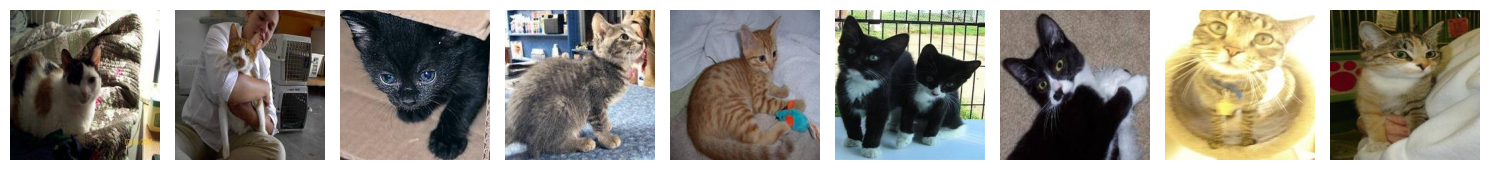

In [17]:
fig, ax = plt.subplots(1, 9, figsize=(15, 15))

for i, image_path in enumerate(cat_images[:9]):
    img = Image.open(f"/content/train/cat/{image_path}")
    ax[i].imshow(img)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
df['label'].value_counts()

,count
label,
dog,12500
cat,12500


In [19]:
test_dir = "/content/test1"

subdirectory = os.path.join(test_dir, "test")
os.makedirs(subdirectory, exist_ok=True)

In [20]:
for file_name in os.listdir(test_dir):
    file_path = os.path.join(test_dir, file_name)
    if os.path.isfile(file_path) and file_name.endswith(".jpg"):
        shutil.move(file_path, subdirectory)

print(f"Todas las imágenes han sido movidas a {subdirectory}")

Todas las imágenes han sido movidas a /content/test1/test


In [21]:
img_size = (224, 224)
batch_size = 32

In [24]:
dummy_subdir = os.path.join(subdirectory, "dummy_class")
os.makedirs(dummy_subdir, exist_ok=True)

for file_name in os.listdir(subdirectory):
    file_path = os.path.join(subdirectory, file_name)
    if os.path.isfile(file_path) and file_name.endswith(".jpg"):
        shutil.move(file_path, dummy_subdir)

print(f"Imágenes movidas a {dummy_subdir}")

Imágenes movidas a /content/test1/test/dummy_class


In [25]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_dataset = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="training"
)

val_dataset = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    subset="validation"
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [26]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_dataset = test_datagen.flow_from_directory(
    subdirectory,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 12500 images belonging to 1 classes.


In [27]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="auto"
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/5
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9611 - loss: 0.0975
Epoch 1: val_accuracy improved from -inf to 0.97140, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 419ms/step - accuracy: 0.9611 - loss: 0.0975 - val_accuracy: 0.9714 - val_loss: 0.0738
Epoch 2/5
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9694 - loss: 0.0769
Epoch 2: val_accuracy improved from 0.97140 to 0.97340, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 409ms/step - accuracy: 0.9694 - loss: 0.0769 - val_accuracy: 0.9734 - val_loss: 0.0624
Epoch 3/5
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9682 - loss: 0.0801
Epoch 3: val_accuracy did not improve from 0.97340
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 406ms/step - accuracy: 0.9683 - loss: 0.0801 - val_accuracy: 0.9734 - val_loss: 0.0711
Epoch 4/5
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9715 - loss: 0.0717
Epoch 4: val_accuracy did not improve from 0.97340
625/625 ━━━━

In [30]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

fine_tuning_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

model.save("final_model.keras")
print("Modelo guardado exitosamente.")

Epoch 1/5
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9111 - loss: 0.2260
Epoch 1: val_accuracy did not improve from 0.97360
625/625 ━━━━━━━━━━━━━━━━━━━━ 306s 416ms/step - accuracy: 0.9112 - loss: 0.2257 - val_accuracy: 0.9726 - val_loss: 0.0722
Epoch 2/5
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9650 - loss: 0.0853
Epoch 2: val_accuracy improved from 0.97360 to 0.98000, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 409ms/step - accuracy: 0.9650 - loss: 0.0852 - val_accuracy: 0.9800 - val_loss: 0.0518
Epoch 3/5
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9714 - loss: 0.0719
Epoch 3: val_accuracy improved from 0.98000 to 0.98320, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 258s 409ms/step - accuracy: 0.9714 - loss: 0.0719 - val_accuracy: 0.9832 - val_loss: 0.0503
Epoch 4/5
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9767 - loss: 0.0609
Epoch 4: val_accuracy improved from 0.98320 to 0.98340, savi

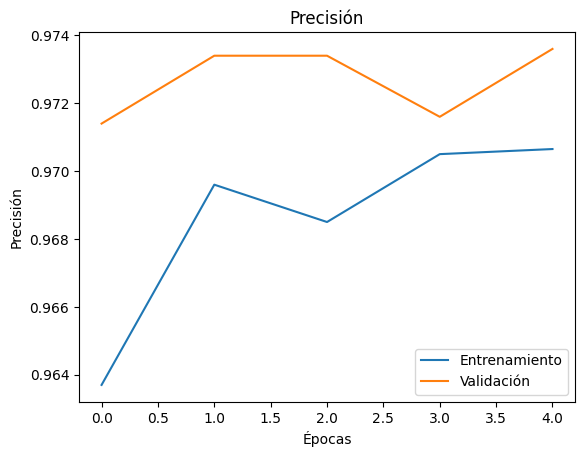

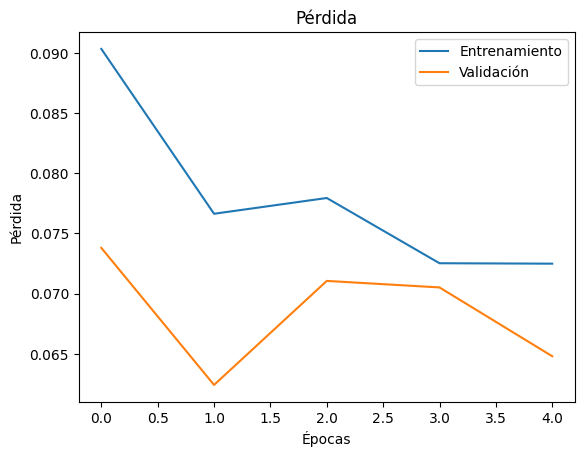

In [42]:
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validación")
plt.title("Precisión")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.title("Pérdida")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

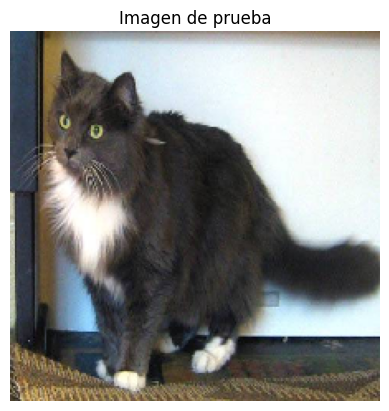

Modelo cargado exitosamente.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicción: Cat
Confianza: 0.00% para clase 'Dog'


<ipython-input-41-ff22fac8051d>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_names[int(output[0] > 0.5)]


In [41]:
img_path = "/content/test1/test/dummy_class/9.jpg"

img = load_img(img_path, target_size=(224, 224))

plt.imshow(img)
plt.axis("off")
plt.title("Imagen de prueba")
plt.show()

img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

saved_model = load_model("/content/final_model.keras")
print("Modelo cargado exitosamente.")

output = saved_model.predict(img_array)

class_names = ["Cat", "Dog"]
predicted_class = class_names[int(output[0] > 0.5)]

print(f"Predicción: {predicted_class}")
print(f"Confianza: {output[0][0] * 100:.2f}% para clase 'Dog'")
